# Setting the environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


## Setup

Installing libraries.

In [ ]:
!pip install pytorch_lightning
!pip install transformers

     |████████████████████████████████| 819kB 12.2MB/s 
     |████████████████████████████████| 645kB 23.3MB/s 
     |████████████████████████████████| 122kB 49.2MB/s 
     |████████████████████████████████| 829kB 50.1MB/s 
     |████████████████████████████████| 235kB 48.6MB/s 
     |████████████████████████████████| 10.6MB 49.6MB/s 
     |████████████████████████████████| 1.3MB 45.7MB/s 
     |████████████████████████████████| 143kB 43.0MB/s 
     |████████████████████████████████| 296kB 47.1MB/s 
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=30a902a29df17930fc78d60f7c5661258a0bdf57196b9423e8153ef5a9760f1c
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built future
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully un

Setting the root folder.

In [ ]:
ROOT = 'drive/MyDrive/Colab_Notebooks/NLP_HW2/'

Now we are going to import the libraries.

In [ ]:
# importing libraries
import string
import re
import os
from typing import *
import math
import random
import pickle
import collections

import json
import xml.etree.ElementTree as ET

from tqdm import tqdm
from pprint import pprint

#Numpy
import numpy as np

#Collections
from collections import defaultdict
from collections import Counter

#Confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score as sk_precision

#Torch
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

#Pytorch lightning
import pytorch_lightning as pl


#Transformers
from transformers import AutoTokenizer, BertModel, AdamW



#NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.corpus import wordnet as wn

#PLT
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


We fix the seed in order to obtain reproducible executions.

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

We set the device on which load the data and the model.

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.cuda.empty_cache()
device

'cuda'

We set the path of the working space and the files.

In [ ]:
path_restaurants_train = ROOT + 'data/restaurants_train.json'
path_restaurants_dev = ROOT + 'data/restaurants_dev.json'

#Vocab

##Vocab class

We define the Vocab class. Objects of this class contain a list mapping integer to string, and a dictionary mapping string to integer.

In [ ]:
class Vocab():

    def __init__(self,
                 counter: Counter,
                 specials: Optional[List] = None,
                 min_freq = 1):
        
        # integer -> string
        self.itos = list()
        
        # string -> integer
        # 1 corresponds to the unknown token string
        self.stoi = defaultdict(lambda: 1)

        i = 0

        # the specials token (pad, unk) are the ones with the smallest integer
        if specials is not None:
            for special in specials:
                self.stoi[special] = i
                i += 1

        # building the stoi dictionary from the counter of the occurences of the strings
        for occ in counter:
            freq = counter[occ]
            if freq >= min_freq:
                self.stoi[occ] = i
                i += 1

        # building the itos list from the stoi dictionary
        for w in self.stoi:
            self.itos.append(w)


##Building vocabs

In [ ]:
# function that build the vocabulary of sentiments
def build_labels_sentiments_vocab():
    print('Building vocabulary of sentiments')
    counter = Counter()
    counter['positive'] = 1
    counter['negative'] = 1
    counter['neutral'] = 1
    counter['conflict'] = 1
    return Vocab(counter)

# function that build the vocabulary of categories
def build_categories_vocab(dataset):
    print('Building vocabulary of categories')
    counter = Counter()
    for raw in tqdm(dataset):
        categories_sentiments = raw['categories_sentiments']
        for category, _ in categories_sentiments:
            counter[category] += 1
    return Vocab(counter)

# function that build the vocabulary of words in the dataset
def build_vocab(dataset, min_freq=1):
    #print('Building vocabulary of words')
    counter = Counter()
    for raw in tqdm(dataset):
        sentence = raw['text']
        for w in sentence.split():
            if w is not None:
                counter[w]+=1
    return Vocab(counter, min_freq=min_freq, specials=['<pad>', '<unk>'])

#Pre-Processing

In this section we are performing the pre-processing step for the sentences. 

In [ ]:
# removing punctuation and multiple spaces
def remove_punctuation(sentence: str):
    
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(8220), ' ') # “
    sentence = sentence.replace(chr(8212), ' ') # —
    sentence = sentence.replace(chr(8211), ' ') # –
    sentence = sentence.replace(chr(8208), ' ') # ‐
    sentence = sentence.replace('\u00a0', '')
    
    sentence = sentence.replace(chr(8216), ' ') # ‘
    sentence = sentence.replace(chr(8217), ' ') # ’
    sentence = sentence.replace(chr(8221), ' ') # ”
    sentence = sentence.replace(chr(39), ' ') # '
    sentence = sentence.replace('/', ' ') # '
    sentence = sentence.replace('.', ' ') # '


    for punc in string.punctuation:
        if punc != '[' and punc != ']' and punc != '-':
            sentence = sentence.replace(punc, '')

    sentence = re.sub(' +', ' ', sentence)

    sentence = sentence.strip()

    return sentence

#Model A

In this section we define the Model and PL Model classes to load the trained model for the task A.

In [ ]:
class AModel(nn.Module):
    
    def __init__(self, hparams, embeddings = None):
    
        super(AModel, self).__init__()
    
        if embeddings is not None:
            self.word_embedding = nn.Embedding.from_pretrained(embeddings)
        else:
            self.word_embedding = nn.Embedding(hparams['vocab_size'], hparams['embedding_dim'])

        self.lstm = nn.LSTM(hparams['embedding_dim'], hparams['hidden_dim'], 
                            bidirectional=hparams['bidirectional'],
                            num_layers=hparams['num_layers'], 
                            dropout = hparams['p_dropout'] if hparams['num_layers'] > 1 else 0)
        
        lstm_output_dim = hparams['hidden_dim'] if hparams['bidirectional'] is False else hparams['hidden_dim'] * 2

        self.dropout = nn.Dropout(hparams['p_dropout'])

        self.classifier = nn.Linear(lstm_output_dim, hparams['num_classes'])

    
    def forward(self, x, lengths):

        embeddings = self.word_embedding(x)

        embeddings = self.dropout(embeddings)

        lengths = lengths.to('cpu')

        out = torch.nn.utils.rnn.pack_padded_sequence(embeddings, 
                                                      lengths=lengths, 
                                                      batch_first=True, 
                                                      enforce_sorted=False)

        out, _ = self.lstm(out)

        out, lengths = torch.nn.utils.rnn.pad_packed_sequence(out, 
                                                              batch_first=True, 
                                                              padding_value=0)
        
        out = self.dropout(out)

        output = self.classifier(out)
        
        return output

In [ ]:
class AModelPL(pl.LightningModule):

    def __init__(self, hparams, embeddings = None, *args, **kwargs):
        super(AModelPL, self).__init__(*args, **kwargs)

        self.save_hyperparameters(hparams)

        self.modelA = AModel(self.hparams, embeddings)
    
    def forward(self, x, lengths):
        logits = self.modelA(x, lengths)
        predictions = torch.argmax(logits, -1)
        return logits, predictions

#Model B

In this section we define the Model and PL Model classes to load the trained model for the task B.

In [ ]:
class BModel(nn.Module):
    
    def __init__(self, p_dropout):
        
        super(BModel, self).__init__()
        
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states = True).to(device)

        self.classifier = torch.nn.Linear(768, 1)

        self.dropout = torch.nn.Dropout(p=p_dropout)
    
    def forward(self, 
                tokens: torch.Tensor, 
                token_type_ids,
                attention_mask
                ):

        batch_size, seq_len = tokens.shape

        bert_embeddings = self.bert(input_ids=tokens, 
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids,
                                    )

        hidden_states = bert_embeddings[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        
        last_hidden_embeddings = token_embeddings[-1]
        
        last_hidden_CLS_embeddings = last_hidden_embeddings[:, 0, :]

        out = self.dropout(last_hidden_CLS_embeddings)

        out = self.classifier(out)

        out = out.squeeze(1)

        out = torch.sigmoid(out)

        return out

In [ ]:
class BModelPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(BModelPL, self).__init__(*args, **kwargs)

        self.save_hyperparameters(hparams)
        
        self.modelB = BModel(p_dropout=self.hparams['p_dropout'])
        
    
    def forward(self, tokens, token_type_ids, attention_mask):
        logits = self.modelB(tokens, token_type_ids, attention_mask)
        return logits

#Evaluation function

In this section there is the code to perform the evaluation of the model.

In [ ]:
# function that takes in input the dictionaries with
# the golds and the predictions for each instance
# the mode allow us to evaluate the category extraction (task C)
# or the category sentiment (task D)
def evaluate(id2golds, id2preds, mode='category extraction'):

    # setting the classes and the scores w.r.t. the mode

    if mode == 'category extraction':
        all_classes = ['anecdotes/miscellaneous', 'service', 'food', 'ambience', 'price']
        scores = {cat: {"TP": 0, "FP": 0, "FN": 0, "TN": 0} for cat in all_classes + ["ALL"]}
    else:
        all_classes = ["positive", "negative", "neutral", "conflict"]
        scores = {cat: {"TP": 0, "FP": 0, "FN": 0} for cat in all_classes + ["ALL"]}
    
    # for each instance
    for id in id2golds:
        
        # for each class (category or sentiment)
        for cur_class in all_classes:
            
            # we consider only the golds and the predictions within the cur_class

            if mode == 'category extraction':
                gold_categories, pred_categories = id2golds[id], id2preds[id]
                pred_cat = set([pred_category for pred_category in pred_categories if pred_category == cur_class])
                gold_cat = set([gold_category for gold_category in gold_categories if gold_category == cur_class])
            else:
                gold_categories_sentiments, pred_categories_sentiments = id2golds[id], id2preds[id]
                pred_cat = set([pred_category for pred_category, pred_sentiment in pred_categories_sentiments if pred_sentiment == cur_class])
                gold_cat = set([gold_category for gold_category, gold_sentiment in gold_categories_sentiments if gold_sentiment == cur_class])

            # computing TP, FP, FN within the cur_class
            scores[cur_class]["TP"] += len(pred_cat & gold_cat)
            scores[cur_class]["FP"] += len(pred_cat - gold_cat)
            scores[cur_class]["FN"] += len(gold_cat - pred_cat)
        
        # if we are evaluating category extraction we can also count the TN
        if mode == 'category extraction':
            scores["ALL"]["TN"] += len(set(all_classes) - set(gold_categories) - set(pred_categories))

    # computing precision, recall, and F1-score for each class
    for cur_class in scores.keys():
        if scores[cur_class]["TP"]:
            scores[cur_class]["P"] = scores[cur_class]["TP"] / (scores[cur_class]["TP"] + scores[cur_class]["FP"])
            scores[cur_class]["R"] = scores[cur_class]["TP"] / (scores[cur_class]["TP"] + scores[cur_class]["FN"])
        else:
            scores[cur_class]["P"], scores[cur_class]["R"] = 0, 0

        if not scores[cur_class]["P"] + scores[cur_class]["R"] == 0:
            scores[cur_class]["F1"] = 2 * scores[cur_class]["P"] * scores[cur_class]["R"] / (
                    scores[cur_class]["P"] + scores[cur_class]["R"])
        else:
            scores[cur_class]["F1"] = 0


    # compute micro precision, micro recall and micro F1-score

    TP = sum([scores[cur_class]["TP"] for cur_class in all_classes])
    FP = sum([scores[cur_class]["FP"] for cur_class in all_classes])
    FN = sum([scores[cur_class]["FN"] for cur_class in all_classes])

    if TP:
        precision = TP / (TP + FP)
        recall = TP / (TP + FN)
        F1 = 2 * precision * recall / (precision + recall)
    else:
        precision, recall, F1 = 0, 0, 0

    scores["ALL"]["P"] = precision
    scores["ALL"]["R"] = recall
    scores["ALL"]["F1"] = F1
    scores["ALL"]["TP"] = TP
    scores["ALL"]["FP"] = FP
    scores["ALL"]["FN"] = FN

    # compute macro precision, macro recall and macro F1-score

    scores["ALL"]["Macro_F1"] = sum([scores[cur_class]["F1"] for cur_class in all_classes])/len(all_classes)
    scores["ALL"]["Macro_P"] = sum([scores[cur_class]["P"] for cur_class in all_classes])/len(all_classes)
    scores["ALL"]["Macro_R"] = sum([scores[cur_class]["R"] for cur_class in all_classes])/len(all_classes)

    # returning scores
    return scores

#Task C

##Dataset C

In [ ]:
class CDataset(torch.utils.data.Dataset):

    def __init__(self, 
                 file_path_restaurants: str,
                 device: str = 'cuda'):

        # device
        self.device = device

        # file path
        self.file_path_restaurants = file_path_restaurants
        
        # data as read from file
        raw_data = self._init_data()
        
        # processed data
        self.data = self._process_data(raw_data)

    # function that load the data from the file
    def _init_data(self):

        with open(self.file_path_restaurants) as f:
            data = json.load(f)

        return data

    # function that process the raw data
    def _process_data(self, raw_data):

        data = []

        # for each instance of the dataset
        for i, instance in tqdm(enumerate(raw_data)):
            
            # retrieving targets, text, and categories
            targets = instance['targets']
            text = instance['text']
            categories_sentiments = instance['categories']

            text = text.replace('")S', '" S')
            
            # dict: (start, end) -> aspect_term
            start_end2aspect = {}

            # dict: (start, end) -> sentiment expressed toward the aspect_term
            start_end2sentiment_label = {}

            # for each target
            for target in targets:
                
                # retrieving the start and the end of the aspect term in the text
                # the aspect_term and the respectively sentiment
                start, end, aspect, sentiment_label = target[0][0], target[0][1], target[1], target[2]

                # store the info in the dictionaries
                start_end2aspect[start, end] = aspect.lower()
                start_end2sentiment_label[start, end] = sentiment_label

            # sort the dictionaries w.r.t. the keys from the end of the text towards the beginning
            start_end2aspect = collections.OrderedDict(sorted(start_end2aspect.items(), reverse=True))
            start_end2sentiment_label = collections.OrderedDict(sorted(start_end2sentiment_label.items(), reverse=True))

            # lowercasing the text
            text = text.lower()

            # removing punctuation from the text
            text = remove_punctuation(text)

            # list of the aspect terms
            aspects = list(start_end2aspect.values())
            aspects.reverse()

            # list of the sentiments about the aspect terms
            sentiment_labels = list(start_end2sentiment_label.values())
            sentiment_labels.reverse() 

            # adding the processed instance to the data
            data.append(
                {
                    'id': i,  
                    'text': text, 
                    'aspects': aspects, 
                    'aspect_sentiment_golds': sentiment_labels, 
                    'categories_sentiments': categories_sentiments
                }
            )

        # returning the processed data
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

##Model C

In [ ]:
class CModel(nn.Module):
    
    def __init__(self, hparams):
        
        super(CModel, self).__init__()
        
        # BERT layer
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states = True).to(device)

        # Dropout
        self.dropout = torch.nn.Dropout(p=hparams['p_dropout'])

        # classifier layer
        self.classifier = nn.Linear(768, hparams['num_classes'])
    
    def forward(self, 
                tokens: torch.Tensor, 
                token_type_ids,
                attention_mask
                ):

        batch_size, seq_len = tokens.shape

        # computing the BERT forward step
        bert_embeddings = self.bert(
            input_ids=tokens,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
        )

        # retrieving all the hidden embeddings for each token
        hidden_states = bert_embeddings[2]
        token_embeddings = torch.stack(hidden_states, dim=0)

        # retrieving the last hidden embeddings for each token
        last_hidden_embeddings = token_embeddings[-1]
        
        # retrieving the last hidden embeddings corresponding to the first [CLS] token
        last_hidden_CLS_embeddings = last_hidden_embeddings[:, 0, :]
        
        # computing dropout
        out = self.dropout(last_hidden_CLS_embeddings)

        # computing the output of the classifier
        out = self.classifier(out)

        # computing the sigmoid function to obtain a value in [0,1]
        out = torch.sigmoid(out)
        
        # returning the output of the model
        return out

##PL

###Datamodule C PL

In this section we are going to define the PL datamodule for Task C.

In [ ]:
class CDataModule(pl.LightningDataModule):
    def __init__(self, 
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device = 'cuda'):
        super().__init__()

        # device
        self.device = device

        # batch_size
        self.batch_size = batch_size

        # file paths
        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def setup(self, stage=None):

        # training dataset
        self.trainingset = CDataset(
            file_path_restaurants=self.path_restaurants_train,
            device=self.device)
        
        # building the vocabulary of the words w.r.t. the training set
        self.vocabulary = build_vocab(self.trainingset, min_freq=1)

        # building the vocabulary of the categories
        self.categories_vocab = build_categories_vocab(self.trainingset)

        # validation dataset
        self.devset = CDataset(
            file_path_restaurants=self.path_restaurants_dev,
            device=self.device)

    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn)

    # collate function
    def _collate_fn(self, samples): 
        
        # ids of the instances
        ids = [sample['id'] for sample in samples]

        # oringinal texts of the instances
        sentences = [sample['text'] for sample in samples]

        # gold categories (and respectively sentiments) of the instances
        categories_sentiments_golds = [sample['categories_sentiments'] for sample in samples]
        
        # discarding the sentiments about the categories
        categories_golds = [[category for category, _ in category_sentiment_gold] for category_sentiment_gold in categories_sentiments_golds]

        # building the ground truth for task C that we would like to predict 
        golds = [[1 if category in category_gold else 0 for category in self.categories_vocab.itos] for category_gold in categories_golds]

        # tokenize the sentence
        tokenized_sentences = self.tokenizer(sentences, padding=True)
        
        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, device=self.device)
        attention_mask = torch.tensor(attention_mask, device=self.device)

        # tensor the ground truth
        golds = [[np.float32(g) for g in gold] for gold in golds]
        golds = torch.tensor(golds, device=self.device)
        
        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'tokens': tokens, 
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'golds': golds
        }

###Model C PL

In this section we are going to define the PL model for Task C.

In [ ]:
class CModelPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(CModelPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)
        
        # model C
        self.modelC = CModel(self.hparams)

        # setting the loss function
        self.loss_function = nn.BCELoss()

        self.n_epoch = 0
        
    # forward step
    def forward(self, tokens, token_type_ids, attention_mask):
        
        # computing the output of the model C
        logits = self.modelC(tokens, token_type_ids, attention_mask)

        # returning the logits
        return logits

    # training step
    def training_step(self, batch, batch_nb):
        
        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']
        
        # computing the forward step for the model C
        out = self.forward(tokens, token_type_ids, attention_mask)

        # computing and logging the loss
        loss_C = self.loss_function(out, golds)
        self.log('train_loss_C', loss_C, prog_bar=True)

        # returning the loss
        return loss_C

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):

        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return

        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']

        # computing the forward step for the model C
        out = self.forward(tokens, token_type_ids, attention_mask)

        # since at least one category must be predicted,
        # we set to 1 the probability of the category corresponding to the 
        # highest probability predicted by the model
        argmax_ = torch.argmax(out, -1)
        for i in range(out.shape[0]):
            out[i][argmax_[i]] = 1

        # rounding the probability to obtain the predictions
        out = torch.round(out).tolist()

        # returning the ids, the predictions and the ground truth
        return (ids, out, golds)

    # end of each validation epoch
    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return

        # merge all the validation step outputs
        ids, preds, golds = [], [], []
        for validation_step_output in validation_step_outputs:
            ids.extend(validation_step_output[0])
            preds.extend(validation_step_output[1])
            golds.extend(validation_step_output[2])

        # dict: id -> binary representation of the gold categories ([0/1, 0/1, 0/1, 0/1, 0/1])
        id2gold_categories = {}
        for id, gold in zip(ids, golds):
            id2gold_categories[id] = gold

        # dict: id -> [gold_cat1, gold_cat2, ....]
        for id in id2gold_categories:
            gold_categories = id2gold_categories[id]
            id2gold_categories[id] = [cdatamodule.categories_vocab.itos[i] 
                                      for i, gold in enumerate(gold_categories) if gold == 1]
        
        # dict: id -> binary representation of the predicted categories ([0/1, 0/1, 0/1, 0/1, 0/1])
        id2pred_categories = {}
        for id, pred in zip(ids, preds):
            id2pred_categories[id] = pred

        # dict: id -> [pred_cat1, pred_cat2, ....]
        for id in id2pred_categories:
            pred_categories = id2pred_categories[id]
            id2pred_categories[id] = [cdatamodule.categories_vocab.itos[i] 
                                      for i, pred in enumerate(pred_categories) if pred == 1]
        
        # EVALUATION

        # computing the evaluation on the task C
        scores = evaluate(
            id2golds=id2gold_categories,
            id2preds=id2pred_categories,
            mode='category extraction'
        )

        # retrieving the scores
        # (Macro-F1, Macro-P, Macro-R, TP, FP, TN, FN)
        scores_ALL = scores['ALL']
        Macro_F1, Macro_P, Macro_R = scores_ALL['Macro_F1'], scores_ALL['Macro_P'], scores_ALL['Macro_R']
        TP, FP, TN, FN = scores_ALL['TP'], scores_ALL['FP'], scores_ALL['TN'], scores_ALL['FN']

        # printing the scores
        print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
        print('Macro precision:', Macro_P)
        print('Macro recall:', Macro_R)
        print('Macro F1:', Macro_F1)
        print()

        # logging the Macro-F1
        self.log('valid_macro_F1', Macro_F1, prog_bar=True)
        
        # saving all these information in the returns dictionary 
        self.returns['scores'] = scores

        RETURNS.append(self.returns)
    
    # optimizer 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams['lr'])

###Datamodule C PL - auxiliary sentences

In this section we are going to define the PL datamodule for Task C in which the auxiliary sententes with the aspect terms are added.

In [ ]:
class CDataModuleAS(pl.LightningDataModule):
    def __init__(self, 
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device = 'cuda'):
        super().__init__()

        # device
        self.device = device

        # batch_size
        self.batch_size = batch_size

        # file paths
        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def setup(self, stage=None):
        
        # training dataset
        self.trainingset = CDataset(
            file_path_restaurants=self.path_restaurants_train,
            device=self.device)
        
        # building the vocabulary of the words w.r.t. the training set
        self.vocabulary = build_vocab(self.trainingset, min_freq=1)

        # building the vocabulary of the categories
        self.categories_vocab = build_categories_vocab(self.trainingset)

        # validation dataset
        self.devset = CDataset(
            file_path_restaurants=self.path_restaurants_dev,
            device=self.device)

    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn_train)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn_dev)

    # function that index the sentence
    # (each word in the sentence is represented by the corresponding integer in the vocabulary)
    def _encode_text(self, sentence: str):

        indices = list()

        for w in sentence.split():
            if w in self.vocabulary.stoi:
                indices.append(self.vocabulary.stoi[w])
            else:
                indices.append(self.vocabulary.stoi['<unk>'])

        return indices

    # collate function for the training dataloader
    def _collate_fn_train(self, samples): 

        # ids of the instances
        ids = [sample['id'] for sample in samples]

        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]

        # auxiliary sentences with the comma-separated list of the aspect terms of the instances
        sentences2 = [', '.join(sample['aspects']) for sample in samples]

        # gold categories (and respectively sentiments) of the instances
        categories_sentiments_golds = [sample['categories_sentiments'] for sample in samples]
        
        # discarding the sentiments about the categories
        categories_golds = [[category for category, _ in category_sentiment_gold] for category_sentiment_gold in categories_sentiments_golds]

        # building the ground truth for task C that we would like to predict 
        golds = [[1 if category in category_gold else 0 for category in self.categories_vocab.itos] for category_gold in categories_golds]

        # tokenize the sentence
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, device=self.device)
        attention_mask = torch.tensor(attention_mask, device=self.device)

        # tensor the ground truth
        golds = [[np.float32(g) for g in gold] for gold in golds]
        golds = torch.tensor(golds, device=self.device)
        
        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'tokens': tokens, 
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'golds': golds
        }

    # collate function for the validation dataloader
    def _collate_fn_dev(self, samples): 
        
        # ids of the instances
        ids = [sample['id'] for sample in samples]

        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]
        
        # gold categories (and respectively sentiments) of the instances
        categories_sentiments_golds = [sample['categories_sentiments'] for sample in samples]
        
        # discarding the sentiments about the categories
        categories_golds = [[category for category, _ in category_sentiment_gold] for category_sentiment_gold in categories_sentiments_golds]

        # encoding the sentences to input the model A
        indexed_sentences1 = [self._encode_text(sentence) for sentence in sentences1]
        
        # computing the lenghts of the sentences
        lengths = [len(indexed_sentence) for indexed_sentence in indexed_sentences1]
        lengths = torch.tensor(lengths, device='cpu')
        
        # tensor the indexed sentences
        indexed_sentences1 = [torch.tensor(indexed_sentence, device=self.device) for indexed_sentence in indexed_sentences1]
        
        # padding the indexed sentences
        indexed_sentences1 = torch.nn.utils.rnn.pad_sequence(
            indexed_sentences1, 
            batch_first=True, 
            padding_value=0
        )

        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'sentences1': sentences1, 
            'categories_golds': categories_golds,
            'lengths': lengths,
            'indexed_sentences1': indexed_sentences1
        }

###Model C PL - auxiliary sentences

In this section we are going to define the PL model for Task C able to handle the auxiliary sententes with the aspect terms.

In [ ]:
class CModelASPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(CModelASPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)

        # model C
        self.modelC = CModel(self.hparams)

        # loading the model A
        self.loaded_model_a = AModelPL.load_from_checkpoint(
            ROOT + FOLDER_A + 'Test n.2/epoch=28-valid_macro_F1=0.8032.ckpt'
        ).to(device)

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        # setting the loss function
        self.loss_function = nn.BCELoss()

        self.n_epoch = 0
        
    # forward step
    def forward(self, tokens, token_type_ids, attention_mask):
        
        # computing the output of the model C
        logits = self.modelC(tokens, token_type_ids, attention_mask)

        # returning the logits
        return logits

    # training step
    def training_step(self, batch, batch_nb):
        
        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']
        
        # computing the forward step for the model C
        out = self.forward(tokens, token_type_ids, attention_mask)

        # computing and logging the loss
        loss_C = self.loss_function(out, golds)
        self.log('train_loss_C', loss_C, prog_bar=True)

        # returning the loss
        return loss_C

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):

        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    
    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return

        ids = batch['ids']
        sentences1 = batch['sentences1'] 
        categories_golds = batch['categories_golds']
        lengths = batch['lengths']
        indexed_sentences1 = batch['indexed_sentences1']

        # obtaining the predictions from the model A
        _, predictionsA = self.loaded_model_a(indexed_sentences1, lengths)
        predictionsA = predictionsA.tolist()

        # deleting the pad from the predicted sequence of BIOs tags
        predictionsA = [predictionsA[i][:l] for i, l in enumerate(lengths)]

        # retrieving the predicted aspect terms for each instance
        aspects = [self._get_aspects(sentence, BIOs) for sentence, BIOs in zip(sentences1, predictionsA)]
        
        # computing the auxiliary sentences as a comma-separated list of the aspect terms of the corresponding instance
        sentences2 = [', '.join(aspect) for aspect in aspects]

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)
        
        # computing the forward step for the model C
        out = self.forward(tokens, token_type_ids, attention_mask)

        # since at least one category must be predicted,
        # we set to 1 the probability of the category corresponding to the 
        # highest probability predicted by the model
        argmax_ = torch.argmax(out, -1)
        for i in range(out.shape[0]):
            out[i][argmax_[i]] = 1

        # rounding the probability to obtain the predictions
        out = torch.round(out).tolist()
        
        # returning the ids, the predictions and the ground truth
        return (ids, out, categories_golds)

    # end of each validation epoch
    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return

        # merge all the validation step outputs
        ids, preds, categories_golds = [], [], []
        for validation_step_output in validation_step_outputs:
            ids.extend(validation_step_output[0])
            preds.extend(validation_step_output[1])
            categories_golds.extend(validation_step_output[2])
        
        # dict: id -> [gold_cat1, gold_cat2, ....]
        id2gold_categories = {}
        for id, gold in zip(ids, categories_golds):
            id2gold_categories[id] = gold

        # dict: id -> binary representation of the predicted categories ([0/1, 0/1, 0/1, 0/1, 0/1])
        id2pred_categories = {}
        for id, pred in zip(ids, preds):
            id2pred_categories[id] = pred

        # dict: id -> [pred_cat1, pred_cat2, ....]
        for id in id2pred_categories:
            pred_categories = id2pred_categories[id]
            id2pred_categories[id] = [cdatamodule.categories_vocab.itos[i] for i, pred in enumerate(pred_categories) if pred == 1]
        

        # EVALUATION

        # computing the evaluation on the task C
        scores = evaluate(
            id2golds=id2gold_categories,
            id2preds=id2pred_categories,
            mode='category extraction'
        )

        # retrieving the scores
        # (Macro-F1, Macro-P, Macro-R, TP, FP, TN, FN)
        scores_ALL = scores['ALL']
        Macro_F1, Macro_P, Macro_R = scores_ALL['Macro_F1'], scores_ALL['Macro_P'], scores_ALL['Macro_R']
        TP, FP, TN, FN = scores_ALL['TP'], scores_ALL['FP'], scores_ALL['TN'], scores_ALL['FN']

        # printing the scores
        print('TP:', TP, 'FP:', FP, 'TN:', TN, 'FN:', FN)
        print('Macro precision:', Macro_P)
        print('Macro recall:', Macro_R)
        print('Macro F1:', Macro_F1)
        print()
        
        # logging the Macro-F1
        self.log('valid_macro_F1', Macro_F1, prog_bar=True)
        
        # saving all these information in the returns dictionary 
        self.returns['scores'] = scores

        RETURNS.append(self.returns)
    
    # function that returns the aspect terms
    # from a text and its BIOs tag sequence
    def _get_aspects(self, sentence, BIOs):

        # split the sentence to obtain a list of words
        splitted_sentence = sentence.split()

        # the list to return
        r = []

        # for each word
        for i, w in enumerate(splitted_sentence):
            
            # if the respectively BIO tag is a B
            # i.e. an aspect is starting
            if BIOs[i] == 2:

                # append in the list to return the starting word of the aspect term
                r.append([w])

                # as long as the following words in the text are part of that aspect term
                # (or the end of the text is reached)
                i += 1
                while i < len(BIOs) and BIOs[i] == 3:
                    
                    # append in the list of the words of the aspect term the word
                    r[-1].append(splitted_sentence[i])
                    i += 1
        
        # join the words components the aspect term in a single string
        r = [' '.join(w for w in s) for s in r] 

        # returning the list of the aspect terms
        return r
        
    # optimizer 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams['lr'])

##Experiments

In [ ]:
FOLDER_A = 'experiments/Task A/'
FOLDER_C = 'experiments/Task C/'

FOLDER = ROOT + FOLDER_C + 'Test n.2/'

# setting the hyper-parameters dictionary
hparams = {
    'AS': True,
    'batch_size': 32,
    'p_dropout': .2,
    'lr': 2e-5
}

In [ ]:
# instantiating the datamodule

if hparams['AS']:

    cdatamodule = CDataModuleAS(
        path_restaurants_train, path_restaurants_dev,
        batch_size=hparams['batch_size'],
        device=device
    )

else:
    cdatamodule = CDataModule(
        path_restaurants_train, path_restaurants_dev,
        batch_size=hparams['batch_size'],
        device=device
    )

cdatamodule.setup()

# setting other hyper-parameters
hparams['num_classes'] = len(cdatamodule.categories_vocab.itos)

2500it [00:00, 46477.37it/s]
100%|██████████| 2500/2500 [00:00<00:00, 732552.75it/s]
541it [00:00, 41838.64it/s]

Building vocabulary of categories


In [ ]:
# saving the itos list of the vocabulary of the categories in a file
print(cdatamodule.categories_vocab.itos)
with open(ROOT + 'vocabulary_categories_itos.txt', 'wb') as vocab_file:
    pickle.dump(cdatamodule.categories_vocab.itos, vocab_file)

In [ ]:
# saving the hyper-parameters in a json file
with open(FOLDER + "hparams.json", "w+") as hparams_file:
    json.dump(hparams, hparams_file)

# callback to save the best checkpoints (w.r.t. the F1-score) 
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_macro_F1',
    verbose=True,
    save_top_k=3,
    mode='max',
    dirpath=FOLDER, 
    filename='{epoch}-{valid_macro_F1:.4f}'
)

# list of dictionaries in which the PL model class will store the information
# about the epoch, the loss and the metrics
RETURNS = []

# PL trainer
trainer = pl.Trainer(gpus=1 if device is 'cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=25,
                     callbacks=[check_point_callback],
                     )

# instantiating the model
if hparams['AS']:
    model = CModelASPL(hparams)
else:
    model = CModelPL(hparams)

# training the model
trainer.fit(model, datamodule=cdatamodule)

# saving the RETURNS list in a file
with open(FOLDER + 'results.pkl', 'wb') as f:
    pickle.dump(RETURNS, f)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NO

Epoch 0, global step 78: valid_macro_F1 reached 0.77128 (best 0.77128), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=0-valid_macro_F1=0.7713.ckpt" as top 3


TP: 514 FP: 102 TN: 1940 FN: 149
Macro precision: 0.8252304222796025
Macro recall: 0.7308639809511519
Macro F1: 0.7712820211191056



Epoch 1, global step 157: valid_macro_F1 reached 0.82893 (best 0.82893), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=1-valid_macro_F1=0.8289.ckpt" as top 3


TP: 543 FP: 90 TN: 1952 FN: 120
Macro precision: 0.8668093689886487
Macro recall: 0.8001216316944223
Macro F1: 0.8289293299668753



Epoch 2, global step 236: valid_macro_F1 reached 0.83570 (best 0.83570), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=2-valid_macro_F1=0.8357.ckpt" as top 3


TP: 553 FP: 95 TN: 1947 FN: 110
Macro precision: 0.8544535602242369
Macro recall: 0.8208156391881843
Macro F1: 0.8356998147909293



Epoch 3, global step 315: valid_macro_F1 reached 0.83666 (best 0.83666), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=3-valid_macro_F1=0.8367.ckpt" as top 3


TP: 547 FP: 93 TN: 1949 FN: 116
Macro precision: 0.8704772506234238
Macro recall: 0.8095013378784601
Macro F1: 0.8366597195103335



Epoch 4, global step 394: valid_macro_F1 reached 0.83239 (best 0.83666), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=4-valid_macro_F1=0.8324.ckpt" as top 3


TP: 560 FP: 104 TN: 1938 FN: 103
Macro precision: 0.8289290932624089
Macro recall: 0.8378394940594248
Macro F1: 0.8323890291014597



Epoch 5, global step 473: valid_macro_F1 was not in top 3


TP: 547 FP: 102 TN: 1940 FN: 116
Macro precision: 0.8497651053407921
Macro recall: 0.816293133544095
Macro F1: 0.8315636487621905



Epoch 6, global step 552: valid_macro_F1 reached 0.83884 (best 0.83884), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=6-valid_macro_F1=0.8388.ckpt" as top 3


TP: 559 FP: 98 TN: 1944 FN: 104
Macro precision: 0.8561279991183133
Macro recall: 0.824282112578312
Macro F1: 0.838842562045809



Epoch 7, global step 631: valid_macro_F1 reached 0.84230 (best 0.84230), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=7-valid_macro_F1=0.8423.ckpt" as top 3


TP: 563 FP: 100 TN: 1942 FN: 100
Macro precision: 0.8624611107349205
Macro recall: 0.8271014042207867
Macro F1: 0.8423036116395861



Epoch 8, global step 710: valid_macro_F1 reached 0.84089 (best 0.84230), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=8-valid_macro_F1=0.8409.ckpt" as top 3


TP: 554 FP: 95 TN: 1947 FN: 109
Macro precision: 0.868093402823399
Macro recall: 0.8215051229343908
Macro F1: 0.8408899506586476



Epoch 9, global step 789: valid_macro_F1 was not in top 3


TP: 558 FP: 107 TN: 1935 FN: 105
Macro precision: 0.8599864395192858
Macro recall: 0.8188193086600493
Macro F1: 0.8345835769150044



Epoch 10, global step 868: valid_macro_F1 reached 0.83906 (best 0.84230), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=10-valid_macro_F1=0.8391.ckpt" as top 3


TP: 566 FP: 104 TN: 1938 FN: 97
Macro precision: 0.8424865929885392
Macro recall: 0.8372356465059599
Macro F1: 0.8390618630927318



Epoch 11, global step 947: valid_macro_F1 was not in top 3


TP: 567 FP: 111 TN: 1931 FN: 96
Macro precision: 0.8268259650949428
Macro recall: 0.8498521073917746
Macro F1: 0.8376246621598135



Epoch 12, global step 1026: valid_macro_F1 reached 0.84350 (best 0.84350), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task C/Test n.2/epoch=12-valid_macro_F1=0.8435.ckpt" as top 3


TP: 567 FP: 99 TN: 1943 FN: 96
Macro precision: 0.8493124287063056
Macro recall: 0.839223687520106
Macro F1: 0.8434987704489897



Epoch 13, global step 1105: valid_macro_F1 was not in top 3


TP: 562 FP: 102 TN: 1940 FN: 101
Macro precision: 0.8412485501919464
Macro recall: 0.8342977697845907
Macro F1: 0.8370731972961926



Epoch 14, global step 1184: valid_macro_F1 was not in top 3


TP: 562 FP: 99 TN: 1943 FN: 101
Macro precision: 0.8558102785939559
Macro recall: 0.8268267579886371
Macro F1: 0.8390698287162219



Epoch 15, global step 1263: valid_macro_F1 was not in top 3


TP: 564 FP: 101 TN: 1941 FN: 99
Macro precision: 0.8462516991864819
Macro recall: 0.836274583350136
Macro F1: 0.8403547198004819



Epoch 16, global step 1342: valid_macro_F1 was not in top 3


TP: 561 FP: 107 TN: 1935 FN: 102
Macro precision: 0.8412932954442993
Macro recall: 0.8281975755046191
Macro F1: 0.8335791162683952



Epoch 17, global step 1421: valid_macro_F1 was not in top 3


TP: 566 FP: 107 TN: 1935 FN: 97
Macro precision: 0.8446356474921031
Macro recall: 0.8345460180229878
Macro F1: 0.838268459188245



Epoch 18, global step 1500: valid_macro_F1 was not in top 3


TP: 566 FP: 107 TN: 1935 FN: 97
Macro precision: 0.8422770553414262
Macro recall: 0.8339124661729282
Macro F1: 0.83668227922467



Epoch 19, global step 1579: valid_macro_F1 was not in top 3


TP: 566 FP: 101 TN: 1941 FN: 97
Macro precision: 0.8511854400719784
Macro recall: 0.8339124661729282
Macro F1: 0.8407575604542694



Epoch 20, global step 1658: valid_macro_F1 was not in top 3


TP: 562 FP: 103 TN: 1939 FN: 101
Macro precision: 0.8466200543581287
Macro recall: 0.83255021970366
Macro F1: 0.8384294750719595



Epoch 21, global step 1737: valid_macro_F1 was not in top 3


TP: 563 FP: 104 TN: 1938 FN: 100
Macro precision: 0.8499006951340615
Macro recall: 0.831079631468366
Macro F1: 0.8388529441175223



Epoch 22, global step 1816: valid_macro_F1 was not in top 3


TP: 566 FP: 104 TN: 1938 FN: 97
Macro precision: 0.847087507124652
Macro recall: 0.8350544721312204
Macro F1: 0.8392746747095521



Epoch 23, global step 1895: valid_macro_F1 was not in top 3


TP: 560 FP: 108 TN: 1934 FN: 103
Macro precision: 0.8358452809567947
Macro recall: 0.8309732612506157
Macro F1: 0.8326124391327246



Epoch 24, global step 1974: valid_macro_F1 was not in top 3


TP: 567 FP: 106 TN: 1936 FN: 96
Macro precision: 0.8451224849858594
Macro recall: 0.8395702078826716
Macro F1: 0.8406963221361448




###Plots

In [ ]:
FOLDER = ROOT + FOLDER_C

models_results = []

# retrieving the models results from the file with the RETURNS list

for i in range(1,3):
    
    with open(FOLDER + 'Test n.' + str(i) + '/' + 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    models_results.append(results)

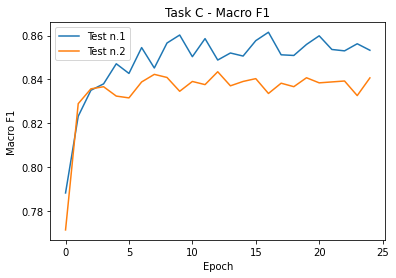

In [ ]:
# plot the F1-score on the validation set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    macro_F1 = [result['scores']['ALL']['Macro_F1'] for result in model_results]
    plt.plot(macro_F1, label='Test n.'+str(i+1))

plt.title('Task C - Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.show()

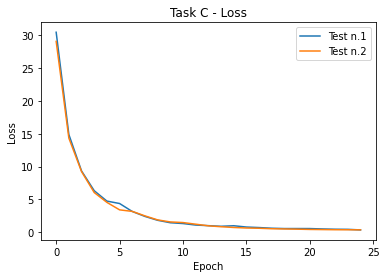

In [ ]:
# plot the loss on the training set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    losses = [result['total_loss'] for result in model_results]
    plt.plot(losses, label='Test n.'+str(i+1))

plt.title('Task C - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

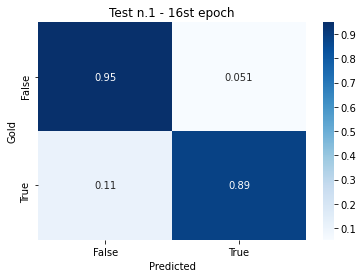

In [ ]:
# plot the confusion matrix of the best model

best_model = models_results[0]
best_epoch_model = best_model[16]

scores_ALL = best_epoch_model['scores']['ALL']

TP, FP, TN, FN = scores_ALL['TP'], scores_ALL['FP'], scores_ALL['TN'], scores_ALL['FN']
                 
cm_data = np.array([[TN, FP], [FN, TP]])

# normalize the confusion matrix
cm_data = cm_data.astype('float') / cm_data.sum(axis=1)[:, np.newaxis]

ax = plt.axes()
sns.heatmap(cm_data, annot=True, cmap='Blues', fmt='.2g', ax=ax, 
            xticklabels=['False', 'True'], yticklabels=['False', 'True'])

ax.set_title('Test n.1 - 16st epoch')
plt.xlabel('Predicted')
plt.ylabel('Gold')
plt.show()

In [ ]:
# printing the saved information about the best model
pprint(best_epoch_model)

{'n_epoch': 16,
 'scores': {'ALL': {'F1': 0.8680913780397936,
                    'FN': 74,
                    'FP': 105,
                    'Macro_F1': 0.861536704671534,
                    'Macro_P': 0.8432673522820668,
                    'Macro_R': 0.8812362313840513,
                    'P': 0.8487031700288185,
                    'R': 0.8883861236802413,
                    'TN': 1937,
                    'TP': 589},
            'ambience': {'F1': 0.8354430379746836,
                         'FN': 10,
                         'FP': 16,
                         'P': 0.8048780487804879,
                         'R': 0.868421052631579,
                         'TN': 0,
                         'TP': 66},
            'anecdotes/miscellaneous': {'F1': 0.8256410256410256,
                                        'FN': 30,
                                        'FP': 38,
                                        'P': 0.8090452261306532,
                                        'R': 0.84

#Task D

##Dataset D

In [ ]:
class DDataset(torch.utils.data.Dataset):

    def __init__(self, 
                 cdataset,
                 mode: str,
                 device: str = 'cuda'):
        
        # device
        self.device = device

        # mode (train or dev)
        self.mode = mode

        # if we instantiate the dataset in train mode
        # the data of the dataset for task C will be processed
        if self.mode == 'train':
            self.data = self._process_data(cdataset.data)
        else:
            self.data = cdataset.data

    # function that process the raw data
    def _process_data(self, raw_data):

        data = []

        # for each instance of the dataset
        for instance in tqdm(raw_data):
            
            # retrieving id, text, aspect terms (with sentiments) and categories (with sentiments)
            id = instance['id']
            text = instance['text']
            aspects = instance['aspects']
            aspect_sentiment_golds = instance['aspect_sentiment_golds']
            categories_sentiments = instance['categories_sentiments']

            # we generate a new instance for each category
            
            for i, (category, sentiment) in enumerate(categories_sentiments):

                # adding the new instance to the data
                data.append(
                    {
                        'id': str(id) + '.' + str(i),
                        'text': text,
                        'aspects': aspects,
                        'aspect_sentiment_golds': aspect_sentiment_golds,
                        'category': category,
                        'category_sentiment_gold': sentiment
                    }
                )
            
        # returning the processed data
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

##Model D

In [ ]:
class DModel(nn.Module):
    
    def __init__(self, hparams):
        
        super(DModel, self).__init__()
        
        # BERT layer
        self.bert = BertModel.from_pretrained(
            'bert-base-uncased',
            output_hidden_states = True).to(device)

        # Dropout
        self.dropout = torch.nn.Dropout(p=hparams['p_dropout'])

        # classifier layer
        self.classifier = nn.Linear(768, hparams['num_classes'])
    
    def forward(self, 
                tokens: torch.Tensor, 
                token_type_ids,
                attention_mask
                ):

        batch_size, seq_len = tokens.shape

        # computing the BERT forward step
        bert_embeddings = self.bert(input_ids=tokens, 
                                    attention_mask=attention_mask,
                                    token_type_ids=token_type_ids,
                                    )

        # retrieving all the hidden embeddings for each token
        hidden_states = bert_embeddings[2]
        token_embeddings = torch.stack(hidden_states, dim=0)
        
        # retrieving the last hidden embeddings for each token
        last_hidden_embeddings = token_embeddings[-1]
        
        # retrieving the last hidden embeddings corresponding to the first [CLS] token
        last_hidden_CLS_embeddings = last_hidden_embeddings[:, 0, :]
        
        # computing dropout
        out = self.dropout(last_hidden_CLS_embeddings)

        # computing the output of the classifier
        out = self.classifier(out)

        # computing the sigmoid function to obtain a value in [0,1]
        out = torch.sigmoid(out)

        # returning the output of the model
        return out

##PL

###Datamodule D PL

In this section we are going to define the PL datamodule for Task D.

In [ ]:
class DDataModule(pl.LightningDataModule):
    def __init__(self, 
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device = 'cuda'):
        super().__init__()

        # device
        self.device = device

        # batch_size
        self.batch_size = batch_size

        # file paths
        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def setup(self, stage=None):

        # training dataset of the task C
        cdataset_train = CDataset(
            file_path_restaurants=self.path_restaurants_train,
            device=self.device
        )
        
        # building the vocabulary of the words w.r.t. the training set
        self.vocabulary = build_vocab(cdataset_train, min_freq=1)

        # building the vocabulary of the categories
        self.categories_vocab = build_categories_vocab(cdataset_train)

        # building the vocabulary of the sentiments
        self.sentiment_vocab = build_labels_sentiments_vocab()

        # training dataset of the task D
        self.trainingset = DDataset(
            cdataset=cdataset_train,
            mode='train',
            device=self.device
        )
        
        # dev dataset of the task C
        cdataset_dev = CDataset(
            file_path_restaurants=self.path_restaurants_dev,
            device=self.device
        )
        
        
        # validation dataset of the task D
        self.devset = DDataset(
            cdataset=cdataset_dev,
            mode='dev',
            device=self.device
        )

        
    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn_train)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn_dev)

    # collate function for the training dataloader
    def _collate_fn_train(self, samples): 

        # ids of the instances
        ids = [sample['id'] for sample in samples]

        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]
        
        # categories of the instances 
        # (one for each instance since we duplicated the input instance for each category)
        categories = [sample['category'] for sample in samples]
        
        # gold sentiments towards the categories
        categories_sentiments_golds = [sample['category_sentiment_gold'] for sample in samples]
        
        # generating the auxiliary sentence (in this case just the category)
        sentences2 = [category for category in categories]

        # tokenize the sentence
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, device=self.device)
        attention_mask = torch.tensor(attention_mask, device=self.device)
    
        # building and tensor the ground truth for task D that we would like to predict 
        golds = [[1 if sent == category_sentiment_gold else 0 for sent in self.sentiment_vocab.itos] for category_sentiment_gold in categories_sentiments_golds]
        golds = [[np.float32(g) for g in gold] for gold in golds]
        golds = torch.tensor(golds, device=self.device)
        
        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'tokens': tokens,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'golds': golds
        }

    # collate function for the validation dataloader
    def _collate_fn_dev(self, samples): 

        # ids of the instances
        ids = [sample['id'] for sample in samples]
        
        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]
        
        # gold categories (and respectively sentiments) of the instances
        categories_sentiments = [sample['categories_sentiments'] for sample in samples]

        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'sentences1': sentences1,
            'categories_sentiments_golds': categories_sentiments,
        }

###Model D PL

In this section we are going to define the PL model for Task D.

In [ ]:
class DModelPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(DModelPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)

        # model D
        self.modelD = DModel(self.hparams)

        # loading the model C
        self.loaded_model_c = CModelPL.load_from_checkpoint(
            ROOT + FOLDER_C + 'Test n.1/epoch=16-valid_macro_F1=0.8615.ckpt'
        ).to(device)

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        # setting the loss function
        self.loss_function = nn.BCELoss()

        self.n_epoch = 0
        
    
    # forward step
    def forward(self, tokens, token_type_ids, attention_mask):
        
        # computing the output of the model D
        logits = self.modelD(tokens, token_type_ids, attention_mask)
        
        # returning the logits
        return logits

    # training step
    def training_step(self, batch, batch_nb):
        
        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']
        
        # computing the forward step for the model D
        out = self.forward(tokens, token_type_ids, attention_mask)

        # computing and logging the loss
        loss_D = self.loss_function(out, golds)
        self.log('train_loss_D', loss_D, prog_bar=True)

        # returning the loss
        return loss_D

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):

        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return

        ids = batch['ids']
        sentences1 = batch['sentences1'] 
        categories_sentiments_golds = batch['categories_sentiments_golds']
        
        # dict: id -> original text
        id2sentences1 = {}
        for id, sentence1 in zip(ids, sentences1):
            id2sentences1[id] = sentence1


        # STARTING MODEL C

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)
        
        # obtaining the predictions from the model C
        predictionsC = self.loaded_model_c(tokens, token_type_ids, attention_mask)
        argmax_ = torch.argmax(predictionsC, -1)
        for i in range(predictionsC.shape[0]):
            predictionsC[i][argmax_[i]] = 1
        predictionsC = torch.round(predictionsC).tolist()

        # dict: id -> binary representation of the predicted categories ([0/1, 0/1, 0/1, 0/1, 0/1])
        id2pred_categories = {}
        for id, pred in zip(ids, predictionsC):
            id2pred_categories[id] = pred

        # dict: id -> [pred_cat1, pred_cat2, ....]
        for id in id2pred_categories:
            pred_categories = id2pred_categories[id]
            id2pred_categories[id] = [ddatamodule.categories_vocab.itos[i] for i, pred in enumerate(pred_categories) if pred == 1]


        # STARTING MODEL D

        # auxiliary sentences
        sentences2 = []

        # new ids for the duplicated instances
        # (one for each predicted category)
        new_ids = []

        # for each instance
        for id in ids:
            
            # retrieving the predicted categories
            categories = id2pred_categories[id]

            # for each predicted categories
            for i, category in enumerate(categories):
                
                # generate a new id and the auxiliary sentence

                new_id = str(id)+'.'+str(i)
                sentence2 = category

                new_ids.append(new_id)
                sentences2.append(sentence2)

        # duplicating the original texts to match each new instance
        sentences1 = []
        for new_id in new_ids:
            id, _ = new_id.split('.')
            sentences1.append(id2sentences1[int(id)])

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)

        # obtaining the predictions from the model D
        predsD = self.forward(tokens, token_type_ids, attention_mask)
        predsD = torch.argmax(predsD, -1).tolist()
        predsD = [ddatamodule.sentiment_vocab.itos[pred] for pred in predsD]

        # dict: id_original_instance -> [pred_sentiment1, pred_sentiment2, ...]
        id2predsD = {}
        for new_id, predD in zip(new_ids, predsD):
            id, _ = new_id.split('.')
            id = int(id)
            if id not in id2predsD:
                id2predsD[id] = [predD]
            else:
                id2predsD[id].append(predD)


        # returning the ids, the gold categories/sentiments, the predicted categories and the predicted sentiments
        return (ids, categories_sentiments_golds, id2predsD, id2pred_categories)


    # end of each validation epoch
    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return

        # merge all the validation step outputs
        ids, categories_sentiments_golds = [], []
        id2predsD, id2pred_categories = {}, {}
        for validation_step_output in validation_step_outputs:
            ids.extend(validation_step_output[0])
            categories_sentiments_golds.extend(validation_step_output[1])
            id2predsD.update(validation_step_output[2])
            id2pred_categories.update(validation_step_output[3])

        # dict: id_instance -> gold categories/sentiments
        id2categories_sentiments_gold = {}
        for id, cats_sents_gold in zip(ids, categories_sentiments_golds):
            id2categories_sentiments_gold[id] = cats_sents_gold

        # dict: id_instance -> predicted categories/sentiments
        id2categories_sentiments_pred = {}
        for id in ids:
            pred_categories = id2pred_categories[id]
            predsD = id2predsD[id]
            id2categories_sentiments_pred[id] = [[cat, sent] for cat, sent in zip(pred_categories, predsD)]

        
        # EVALUATION

        # computing the evaluation on the task C
        scores = evaluate(
            id2golds=id2categories_sentiments_gold,
            id2preds=id2categories_sentiments_pred,
            mode='category sentiment'
        )

        # retrieving the scores
        # (Macro-F1, Macro-P, Macro-R, TP, FP, FN)
        scores_ALL = scores['ALL']
        Macro_F1, Macro_P, Macro_R = scores_ALL['Macro_F1'], scores_ALL['Macro_P'], scores_ALL['Macro_R']
        TP, FP, FN = scores_ALL['TP'], scores_ALL['FP'], scores_ALL['FN']


        # printing the scores
        print('TP:', TP, 'FP:', FP, 'FN:', FN)
        print('Macro precision:', Macro_P)
        print('Macro recall:', Macro_R)
        print('Macro F1:', Macro_F1)
        print()

        # logging the Macro-F1
        self.log('valid_macro_F1', Macro_F1, prog_bar=True)
        
        # saving all these information in the returns dictionary 
        self.returns['scores'] = scores

        RETURNS.append(self.returns)

    
    # optimizer 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams['lr'])

###Datamodule D PL - auxiliary sentences

In this section we are going to define the PL datamodule for Task D in which the auxiliary sententes are composed by the category and the comma-separated list of the the aspect terms and respectively sentiments.

In [ ]:
class DDataModuleAS(pl.LightningDataModule):
    def __init__(self, 
                 path_restaurants_train,
                 path_restaurants_dev,
                 batch_size,
                 device = 'cuda'):
        super().__init__()

        # device
        self.device = device

        # batch_size
        self.batch_size = batch_size

        # file paths
        self.path_restaurants_train = path_restaurants_train
        self.path_restaurants_dev = path_restaurants_dev

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

    def setup(self, stage=None):

        # training dataset of the task C
        cdataset_train = CDataset(
            file_path_restaurants=self.path_restaurants_train,
            device=self.device)
        
        # building the vocabulary of the words w.r.t. the training set
        self.vocabulary = build_vocab(cdataset_train, min_freq=1)
        
        # building the vocabulary of the categories
        self.categories_vocab = build_categories_vocab(cdataset_train)
        
        # building the vocabulary of the sentiments
        self.sentiment_vocab = build_labels_sentiments_vocab()

        # training dataset of the task D
        self.trainingset = DDataset(
            cdataset=cdataset_train,
            mode='train',
            device=self.device)
        
        # dev dataset of the task C
        cdataset_dev = CDataset(
            file_path_restaurants=self.path_restaurants_dev,
            device=self.device)
        
        # validation dataset of the task D
        self.devset = DDataset(
            cdataset=cdataset_dev,
            mode='dev',
            device=self.device)
        
    # training dataloader
    def train_dataloader(self):
        return DataLoader(self.trainingset, batch_size=self.batch_size, collate_fn=self._collate_fn_train)
    
    # validation dataloader
    def val_dataloader(self):
        return DataLoader(self.devset, batch_size=self.batch_size, collate_fn=self._collate_fn_dev)

    # function that index the sentence
    # (each word in the sentence is represented by the corresponding integer in the vocabulary)
    def _encode_text(self, sentence: str):

        indices = list()

        for w in sentence.split():
            if w in self.vocabulary.stoi:
                indices.append(self.vocabulary.stoi[w])
            else:
                indices.append(self.vocabulary.stoi['<unk>'])

        return indices

    # collate function for the training dataloader
    def _collate_fn_train(self, samples): 

        # ids of the instances
        ids = [sample['id'] for sample in samples]
        
        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]
        
        # gold aspect terms of the instances
        aspects = [sample['aspects'] for sample in samples]
        
        # gold sentiments about the aspect terms of the instances
        aspect_sentiment_golds = [sample['aspect_sentiment_golds'] for sample in samples]
        
        # gold categories of the instances
        categories = [sample['category'] for sample in samples]
        
        # gold sentiments about the categoriesof the instances
        categories_sentiments_golds = [sample['category_sentiment_gold'] for sample in samples]
        
        # generating the auxiliary sentences of the shape
        # category - aspect_term1:sentiment1, aspect_term2:sentiment2, ... 
        aspects_sentiments = [[a+':'+s for a, s in zip(aspects_, aspect_sentiment_golds_)] for aspects_, aspect_sentiment_golds_ in zip(aspects, aspect_sentiment_golds)]
        sentences2 = [', '.join(aspects_sentiments_) for aspects_sentiments_ in aspects_sentiments]
        sentences2 = [category+' - '+sentence for sentence, category in zip(sentences2, categories)]

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=self.device)
        token_type_ids = torch.tensor(token_type_ids, device=self.device)
        attention_mask = torch.tensor(attention_mask, device=self.device)

        # building and tensor the ground truth for task D that we would like to predict 
        golds = [[1 if sent == category_sentiment_gold else 0 for sent in self.sentiment_vocab.itos] for category_sentiment_gold in categories_sentiments_golds]
        golds = [[np.float32(g) for g in gold] for gold in golds]
        golds = torch.tensor(golds, device=self.device)
        
        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'tokens': tokens,
            'token_type_ids': token_type_ids,
            'attention_mask': attention_mask,
            'golds': golds
        }

    # collate function for the validation dataloader
    def _collate_fn_dev(self, samples): 

        # ids of the instances
        ids = [sample['id'] for sample in samples]
        
        # original texts of the instances
        sentences1 = [sample['text'] for sample in samples]
        
        # gold categories (and respectively sentiments) of the instances
        categories_sentiments = [sample['categories_sentiments'] for sample in samples]

        # encoding the sentences to input the model A
        indexed_sentences1 = [self._encode_text(sentence) for sentence in sentences1]
        
        # computing the lenghts of the sentences
        lengths = [len(indexed_sentence) for indexed_sentence in indexed_sentences1]
        lengths = torch.tensor(lengths, device='cpu')
        
        # tensor the indexed sentences
        indexed_sentences1 = [torch.tensor(indexed_sentence, device=self.device) for indexed_sentence in indexed_sentences1]
        
        # padding the indexed sentences
        indexed_sentences1 = torch.nn.utils.rnn.pad_sequence(
            indexed_sentences1, 
            batch_first=True, 
            padding_value=0)

        # returning the dictionary with the batched instances
        return {
            'ids': ids,
            'sentences1': sentences1,
            'categories_sentiments_golds': categories_sentiments,
            'lengths': lengths,
            'indexed_sentences1': indexed_sentences1
        }

###Model D PL - auxiliary sentences

In this section we are going to define the PL model for Task D able to handle the auxiliary sententes composed by the category and the comma-separated list of the the aspect terms and respectively sentiments.

In [ ]:
class DModelASPL(pl.LightningModule):

    def __init__(self, hparams, *args, **kwargs):
        super(DModelASPL, self).__init__(*args, **kwargs)

        # saving hyper-parameters
        self.save_hyperparameters(hparams)

        # model D
        self.modelD = DModel(self.hparams)

        # loading the model A
        self.loaded_model_a = AModelPL.load_from_checkpoint(
            ROOT + FOLDER_A + 'Test n.2/epoch=28-valid_macro_F1=0.8032.ckpt'
        ).to(device)
        
        # loading the model B
        self.loaded_model_b = BModelPL.load_from_checkpoint(
            ROOT + FOLDER_B + 'Test n.3/epoch=10-valid_macro_F1=0.6395.ckpt'
        ).to(device)

        # loading the model C
        self.loaded_model_c = CModelASPL.load_from_checkpoint(
            ROOT + FOLDER_C + 'Test n.2/epoch=12-valid_macro_F1=0.8435.ckpt'
        ).to(device)

        # BERT pre-trained tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')

        # setting the loss function
        self.loss_function = nn.BCELoss()

        self.n_epoch = 0
        
    
    # forward step
    def forward(self, tokens, token_type_ids, attention_mask):
        
        # computing the output of the model D
        logits = self.modelD(tokens, token_type_ids, attention_mask)
        
        # returning the logits
        return logits

    # training step
    def training_step(self, batch, batch_nb):
        
        ids = batch['ids']
        tokens = batch['tokens'] 
        token_type_ids = batch['token_type_ids']
        attention_mask = batch['attention_mask']
        golds = batch['golds']
        
        # computing the forward step for the model D
        out = self.forward(tokens, token_type_ids, attention_mask)

        # computing and logging the loss
        loss_D = self.loss_function(out, golds)
        self.log('train_loss_D', loss_D, prog_bar=True)

        # returning the loss
        return loss_D

    # end of each training epoch
    def training_epoch_end(self, training_step_outputs):

        # saving the number of the ended epoch and the total loss on the training set 
        # in a dictionary

        total_loss = 0
        for loss in training_step_outputs:
            total_loss += loss['loss'].item()

        self.returns = dict()
        
        self.returns['n_epoch'] = self.n_epoch
        self.returns['total_loss'] = total_loss

        self.n_epoch += 1

    # validation step
    def validation_step(self, batch, batch_nb):
        
        if self.n_epoch == 0:
            return
            

        ids = batch['ids']
        sentences1 = batch['sentences1'] 
        categories_sentiments_golds = batch['categories_sentiments_golds']
        lengths = batch['lengths']
        indexed_sentences1 = batch['indexed_sentences1']

        # dict: id -> original text
        id2sentences1 = {}
        for id, sentence1 in zip(ids, sentences1):
            id2sentences1[id] = sentence1


        # STARTING MODEL A

        # obtaining the predictions from the model A
        _, predictionsA = self.loaded_model_a(indexed_sentences1, lengths)
        predictionsA = predictionsA.tolist()

        # deleting the pad from the predicted sequence of BIOs tags
        predictionsA = [predictionsA[i][:l] for i, l in enumerate(lengths)]
        
        # retrieving the predicted aspect terms for each instance
        aspects = [self._get_aspects(sentence, BIOs) for sentence, BIOs in zip(sentences1, predictionsA)]

        # dict: id -> [aspect_term1, aspect_term2, ...]
        id2aspects = {}
        for i, id in enumerate(ids):
            id2aspects[id] = aspects[i]


        # STARTING MODEL C

        # computing the auxiliary sentences for the model C as a comma-separated list of the aspect terms of the corresponding instance
        sentences2 = [', '.join(aspect) for aspect in aspects]

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)
        
        # obtaining the predictions from the model C
        predictionsC = self.loaded_model_c(tokens, token_type_ids, attention_mask)
        argmax_ = torch.argmax(predictionsC, -1)
        for i in range(predictionsC.shape[0]):
            predictionsC[i][argmax_[i]] = 1
        predictionsC = torch.round(predictionsC).tolist()


        # dict: id -> binary representation of the predicted categories ([0/1, 0/1, 0/1, 0/1, 0/1])
        id2pred_categories = {}
        for id, pred in zip(ids, predictionsC):
            id2pred_categories[id] = pred

        # dict: id -> [pred_cat1, pred_cat2, ....]
        for id in id2pred_categories:
            pred_categories = id2pred_categories[id]
            id2pred_categories[id] = [ddatamodule.categories_vocab.itos[i] for i, pred in enumerate(pred_categories) if pred == 1]


        # STARTING MODEL B

        # associating to each word the predicted BIO tag by the model A
        sentences_BIOs = [list(zip(sentence.split(), prediction)) for sentence, prediction in zip(sentences1, predictionsA)]
        
        # function that duplicate the instances for each sentiment generating the auxiliary sentences
        sentence_pairs = self._generate_sentence_pairs_data(
            # function that duplicate the instances for each aspect term in the text
            self._generate_sentence_aspect_pairs(
                sentences_BIOs, ids
            )
        )
        
        # retrieving the new ids
        new_ids = [sentence_pair[0] for sentence_pair in sentence_pairs]
        
        # retrieving the original texts
        sentences1 = [sentence_pair[1] for sentence_pair in sentence_pairs]
        
        # retrieving the auxiliary sentences
        sentences2 = [sentence_pair[2] for sentence_pair in sentence_pairs]

        # dict: id -> [pred_sentiment1, pred_sentiment2, ...]
        id2predB = {}

        if new_ids:

            # tokenize the sentences
            tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

            tokens = tokenized_sentences['input_ids']
            token_type_ids = tokenized_sentences['token_type_ids']
            attention_mask = tokenized_sentences['attention_mask']

            tokens = torch.tensor(tokens, device=device)
            token_type_ids = torch.tensor(token_type_ids, device=device)
            attention_mask = torch.tensor(attention_mask, device=device)

            # obtaining the predictions from the model B
            out2 = self.loaded_model_b(tokens, token_type_ids, attention_mask)
            out2 = out2.reshape(len(out2)//4, 4)
            predictionsB = torch.argmax(out2, -1).tolist()

            # dict: id_instance_aspect -> predicted sentiment
            id_n_aspect2predB = {}
            for i in range(0, len(new_ids), 4):
                id, n_aspect, _ = new_ids[i].split('.')
                id_n_aspect2predB[id + '.' + n_aspect] = predictionsB[i//4]

            # initializating the id2predB dict for each id
            for id in ids:
                id2predB[id] = []

            # storing the predicted list of sentiments (as integer) in the id2predB dict for each id
            for id_n_aspect in id_n_aspect2predB:
                id, n_aspect = id_n_aspect.split('.')
                id2predB[int(id)].append(id_n_aspect2predB[id_n_aspect])

            # converting the integer representation of the sentiment in the corresponding string
            for id in id2predB:
                pred = id2predB[id]
                id2predB[id] = [ddatamodule.sentiment_vocab.itos[p] for p in pred]


        # STARTING MODEL D

        # auxiliary sentences
        sentences2 = []


        # new ids for the duplicated instances
        # (one for each predicted category)
        new_ids = []

        # for each instance
        for id in ids:
            
            # retrieving the predicted aspect terms by the model A
            aspects = id2aspects[id]
            
            # retrieving the predicted sentiments about the aspect terms by the model B
            predB = id2predB[id]
            
            # retrieving the predicted categories by the model C
            categories = id2pred_categories[id]

            # building the comma-separated list of the aspect terms and respectively sentiments
            aspects_sentiments = ', '.join(aspect+':'+aspect_sentiment for aspect, aspect_sentiment in zip(aspects, predB))
            
            # for each predicted categories
            for i, category in enumerate(categories):
            
                # generate a new id and the auxiliary sentence

                new_id = str(id)+'.'+str(i)
                sentence = category + ' - ' + aspects_sentiments
            
                new_ids.append(new_id)
                sentences2.append(sentence)

        # duplicating the original texts to match each new instance
        sentences1 = []
        for new_id in new_ids:
            id, _ = new_id.split('.')
            sentences1.append(id2sentences1[int(id)])

        # tokenize the sentences
        tokenized_sentences = self.tokenizer(sentences1, sentences2, padding=True)

        tokens = tokenized_sentences['input_ids']
        token_type_ids = tokenized_sentences['token_type_ids']
        attention_mask = tokenized_sentences['attention_mask']

        tokens = torch.tensor(tokens, device=device)
        token_type_ids = torch.tensor(token_type_ids, device=device)
        attention_mask = torch.tensor(attention_mask, device=device)

        # obtaining the predictions from the model D
        predsD = self.forward(tokens, token_type_ids, attention_mask)
        predsD = torch.argmax(predsD, -1).tolist()
        predsD = [ddatamodule.sentiment_vocab.itos[pred] for pred in predsD]

        # dict: id_original_instance -> [pred_sentiment1, pred_sentiment2, ...]
        id2predsD = {}
        for new_id, predD in zip(new_ids, predsD):
            id, _ = new_id.split('.')
            id = int(id)
            if id not in id2predsD:
                id2predsD[id] = [predD]
            else:
                id2predsD[id].append(predD)

        # returning the ids, the gold categories/sentiments, the predicted categories and the predicted sentiments
        return (ids, categories_sentiments_golds, id2predsD, id2pred_categories)


    def validation_epoch_end(self, validation_step_outputs):
        
        if self.n_epoch == 0:
            return

        # merge all the validation step outputs
        ids, categories_sentiments_golds = [], []
        id2predsD, id2pred_categories = {}, {}
        for validation_step_output in validation_step_outputs:
            ids.extend(validation_step_output[0])
            categories_sentiments_golds.extend(validation_step_output[1])
            id2predsD.update(validation_step_output[2])
            id2pred_categories.update(validation_step_output[3])


        # dict: id_instance -> gold categories/sentiments
        id2categories_sentiments_gold = {}
        for id, cats_sents_gold in zip(ids, categories_sentiments_golds):
            id2categories_sentiments_gold[id] = cats_sents_gold

        # dict: id_instance -> predicted categories/sentiments
        id2categories_sentiments_pred = {}
        for id in ids:
            pred_categories = id2pred_categories[id]
            predsD = id2predsD[id]
            id2categories_sentiments_pred[id] = [[cat, sent] for cat, sent in zip(pred_categories, predsD)]


        # EVALUATION

        # computing the evaluation on the task C
        scores = evaluate(
            id2golds=id2categories_sentiments_gold,
            id2preds=id2categories_sentiments_pred,
            mode='category sentiment'
        )

        # retrieving the scores
        # (Macro-F1, Macro-P, Macro-R, TP, FP, FN)
        scores_ALL = scores['ALL']
        Macro_F1, Macro_P, Macro_R = scores_ALL['Macro_F1'], scores_ALL['Macro_P'], scores_ALL['Macro_R']
        TP, FP, FN = scores_ALL['TP'], scores_ALL['FP'], scores_ALL['FN']


        # printing the scores
        print('TP:', TP, 'FP:', FP, 'FN:', FN)
        print('Macro precision:', Macro_P)
        print('Macro recall:', Macro_R)
        print('Macro F1:', Macro_F1)
        print()

        # logging the Macro-F1
        self.log('valid_macro_F1', Macro_F1, prog_bar=True)
        
        # saving all these information in the returns dictionary 
        self.returns['scores'] = scores

        RETURNS.append(self.returns)

    # SAME FUNCTION OF THE DATASET B
    # function that duplicate the instances for each aspect term in the text
    def _generate_sentence_aspect_pairs(self, sentences_BIOs, ids):
        
        data = []

        id2start_aspect2list_index_aspect = {}


        for id, sentence_BIOs in zip(ids, sentences_BIOs):
            
            id2start_aspect2list_index_aspect[id] = {}

            sentence = ' '.join([w for w, _ in sentence_BIOs])

            for i, (w, BIO) in enumerate(sentence_BIOs):

                if BIO == 2: #'B'
                    id2start_aspect2list_index_aspect[id][i] = ([i])
                    j = i + 1 
                    while j < len(sentence_BIOs) and sentence_BIOs[j][1] == 3: #'I'
                        id2start_aspect2list_index_aspect[id][i].append(j)
                        j += 1
            
            if len(id2start_aspect2list_index_aspect[id].keys()) > 0:
                data.append(
                    (id, sentence, id2start_aspect2list_index_aspect[id])
                    )

        return_data = []

        for id, sentence, start_aspect2indexes_aspect in data:
            
            sentence_splitted = sentence.split()
            j = 0
            
            for start in start_aspect2indexes_aspect:
                indexes_aspect = start_aspect2indexes_aspect[start]
                end = indexes_aspect[-1]

                sentence1 = ''

                for i, w in enumerate(sentence_splitted):
                    
                    if i == start and i == end:
                        sentence1 += '"'
                        sentence1 += w
                        sentence1 += '" '
                                     
                    elif i == start:
                        sentence1 += '"'
                        sentence1 += (w + ' ')

                    elif i == end:
                        sentence1 += w
                        sentence1 += '" '

                    else:
                        sentence1 += (w + ' ')
                
                aspect = ' '.join(sentence_splitted[start:end+1])

                sentence1 = sentence1.strip()
                aspect = aspect.strip()
                
                id_n_aspect = str(id) + '.' + str(j)

                return_data.append(
                    (id_n_aspect, sentence1, aspect)
                )

                j += 1

        return return_data

    # SAME FUNCTION OF THE DATASET B
    # function that duplicate the instances for each sentiment generating the auxiliary sentences
    def _generate_sentence_pairs_data(self, sentence_aspect_pairs_data):

        data = []

        for id, sentence1, aspect in sentence_aspect_pairs_data:

            for i_label, label in enumerate(ddatamodule.sentiment_vocab.itos):

                sentence2 = aspect + ':' + label

                new_id = str(id) + '.' + str(i_label)

                data.append(
                    (new_id, sentence1, sentence2)
                )

        return data
        

    # function that returns the aspect terms from a text and its BIOs tag sequence
    def _get_aspects(self, sentence, BIOs):

        splitted_sentence = sentence.split()

        r = []

        for i, w in enumerate(splitted_sentence):
            if BIOs[i] == 2:
                r.append([w])
                i += 1
                while i < len(BIOs) and BIOs[i] == 3:
                    r[-1].append(splitted_sentence[i])
                    i += 1

        r = [' '.join(w for w in s) for s in r]

        return r
    
    # optimizer 
    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams['lr'])

##Experiments

In [ ]:
FOLDER_A = 'experiments/Task A/'
FOLDER_B = 'experiments/Task B/'
FOLDER_C = 'experiments/Task C/'
FOLDER_D = 'experiments/Task D/'

FOLDER = ROOT + FOLDER_D + 'Test n.2/'

# setting the hyper-parameters dictionary
hparams = {
    'AS': True,
    'batch_size': 32,
    'p_dropout': .2,
    'lr': 2e-5
}

In [ ]:
# instantiating the datamodule

if hparams['AS']:

    ddatamodule = DDataModuleAS(
        path_restaurants_train, 
        path_restaurants_dev,
        batch_size=hparams['batch_size'],
        device=device)
    
else:
    
    ddatamodule = DDataModule(
        path_restaurants_train, 
        path_restaurants_dev,
        batch_size=hparams['batch_size'],
        device=device)

ddatamodule.setup()

# setting other hyper-parameters
hparams['num_classes'] = len(ddatamodule.sentiment_vocab.itos)

2500it [00:00, 28467.23it/s]
100%|██████████| 2500/2500 [00:00<00:00, 374397.83it/s]
541it [00:00, 35697.61it/s]

Building vocabulary of categories
Building vocabulary of sentiments


In [ ]:
ddatamodule.sentiment_vocab.itos

['positive', 'negative', 'neutral', 'conflict']

In [ ]:
# saving the hyper-parameters in a json file
with open(FOLDER + "hparams.json", "w+") as hparams_file:
    json.dump(hparams, hparams_file)

# callback to save the best checkpoints (w.r.t. the F1-score) 
check_point_callback = pl.callbacks.ModelCheckpoint(
    monitor='valid_macro_F1',
    verbose=True,
    save_top_k=3,
    mode='max',
    dirpath=FOLDER, 
    filename='{epoch}-{valid_macro_F1:.4f}'
)

# list of dictionaries in which the PL model class will store the information
# about the epoch, the loss and the metrics
RETURNS = []

# PL trainer
trainer = pl.Trainer(gpus=1 if device is 'cuda' else 0, 
                     val_check_interval=1.0, 
                     max_epochs=35,
                     callbacks=[check_point_callback],
                     )

# instantiating the model
if hparams['AS']:
    model = DModelASPL(hparams)
else:
    model = DModelPL(hparams)

# training the model
trainer.fit(model, datamodule=ddatamodule)

# saving the RETURNS list in a file
with open(FOLDER + 'results.pkl', 'wb') as f:
    pickle.dump(RETURNS, f)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:360: UserWarning: Checkpoint directory drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/ exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NO

Epoch 0, global step 95: valid_macro_F1 reached 0.53344 (best 0.53344), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=0-valid_macro_F1=0.5334.ckpt" as top 3


TP: 447 FP: 219 FN: 216
Macro precision: 0.6019849227569816
Macro recall: 0.5121092249038588
Macro F1: 0.5334372652257389



Epoch 1, global step 191: valid_macro_F1 reached 0.57926 (best 0.57926), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=1-valid_macro_F1=0.5793.ckpt" as top 3


TP: 462 FP: 204 FN: 201
Macro precision: 0.6416714131970628
Macro recall: 0.5548743439912953
Macro F1: 0.5792569767527324



Epoch 2, global step 287: valid_macro_F1 reached 0.58145 (best 0.58145), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=2-valid_macro_F1=0.5814.ckpt" as top 3


TP: 454 FP: 212 FN: 209
Macro precision: 0.576700827253597
Macro recall: 0.5953391092084184
Macro F1: 0.581449272273328



Epoch 3, global step 383: valid_macro_F1 reached 0.57581 (best 0.58145), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=3-valid_macro_F1=0.5758.ckpt" as top 3


TP: 454 FP: 212 FN: 209
Macro precision: 0.5709090640533485
Macro recall: 0.5892514694724283
Macro F1: 0.5758087703731519



Epoch 4, global step 479: valid_macro_F1 reached 0.59136 (best 0.59136), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=4-valid_macro_F1=0.5914.ckpt" as top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5950492675433666
Macro recall: 0.591896854344491
Macro F1: 0.5913606567473737



Epoch 5, global step 575: valid_macro_F1 reached 0.58694 (best 0.59136), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=5-valid_macro_F1=0.5869.ckpt" as top 3


TP: 463 FP: 203 FN: 200
Macro precision: 0.5937505872464817
Macro recall: 0.5866591314375252
Macro F1: 0.5869407334553634



Epoch 6, global step 671: valid_macro_F1 was not in top 3


TP: 459 FP: 207 FN: 204
Macro precision: 0.588705016538703
Macro recall: 0.5714872280532824
Macro F1: 0.5789144435141029



Epoch 7, global step 767: valid_macro_F1 was not in top 3


TP: 455 FP: 211 FN: 208
Macro precision: 0.5737443913735707
Macro recall: 0.5666759621772703
Macro F1: 0.5685450287248477



Epoch 8, global step 863: valid_macro_F1 reached 0.58972 (best 0.59136), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=8-valid_macro_F1=0.5897.ckpt" as top 3


TP: 463 FP: 203 FN: 200
Macro precision: 0.6126453903137805
Macro recall: 0.5747543013654198
Macro F1: 0.5897231479187743



Epoch 9, global step 959: valid_macro_F1 reached 0.59748 (best 0.59748), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=9-valid_macro_F1=0.5975.ckpt" as top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.6071307819781344
Macro recall: 0.5894081134923863
Macro F1: 0.5974820813260098



Epoch 10, global step 1055: valid_macro_F1 was not in top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5884734358197389
Macro recall: 0.5738661449243748
Macro F1: 0.5770570481113231



Epoch 11, global step 1151: valid_macro_F1 reached 0.61348 (best 0.61348), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=11-valid_macro_F1=0.6135.ckpt" as top 3


TP: 468 FP: 198 FN: 195
Macro precision: 0.6138603124477224
Macro recall: 0.6131498041296045
Macro F1: 0.6134778166871377



Epoch 12, global step 1247: valid_macro_F1 was not in top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5848279112088295
Macro recall: 0.589272888792449
Macro F1: 0.5863864725307335



Epoch 13, global step 1343: valid_macro_F1 was not in top 3


TP: 454 FP: 212 FN: 209
Macro precision: 0.5698399637830899
Macro recall: 0.5872501952862453
Macro F1: 0.5778519574235357



Epoch 14, global step 1439: valid_macro_F1 reached 0.59894 (best 0.61348), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=14-valid_macro_F1=0.5989.ckpt" as top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5839413979201005
Macro recall: 0.6263986297915378
Macro F1: 0.5989355871916476



Epoch 15, global step 1535: valid_macro_F1 was not in top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5872716056038769
Macro recall: 0.5730340325533722
Macro F1: 0.5760534737277752



Epoch 16, global step 1631: valid_macro_F1 reached 0.60500 (best 0.61348), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=16-valid_macro_F1=0.6050.ckpt" as top 3


TP: 462 FP: 204 FN: 201
Macro precision: 0.5932781723982449
Macro recall: 0.6201513675624698
Macro F1: 0.6049953715787252



Epoch 17, global step 1727: valid_macro_F1 reached 0.60721 (best 0.61348), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=17-valid_macro_F1=0.6072.ckpt" as top 3


TP: 462 FP: 204 FN: 201
Macro precision: 0.6015164154422123
Macro recall: 0.6159908057074563
Macro F1: 0.6072087107356632



Epoch 18, global step 1823: valid_macro_F1 was not in top 3


TP: 467 FP: 199 FN: 196
Macro precision: 0.6044402209226771
Macro recall: 0.5722553335564341
Macro F1: 0.5830649703290104



Epoch 19, global step 1919: valid_macro_F1 was not in top 3


TP: 458 FP: 208 FN: 205
Macro precision: 0.5873200893034405
Macro recall: 0.5924443464793593
Macro F1: 0.5891690233178138



Epoch 20, global step 2015: valid_macro_F1 was not in top 3


TP: 460 FP: 206 FN: 203
Macro precision: 0.5895788052792665
Macro recall: 0.5887356236144616
Macro F1: 0.5871153252968977



Epoch 21, global step 2111: valid_macro_F1 was not in top 3


TP: 455 FP: 211 FN: 208
Macro precision: 0.5673373694207028
Macro recall: 0.5861690715951515
Macro F1: 0.571839288491703



Epoch 22, global step 2207: valid_macro_F1 reached 0.60645 (best 0.61348), saving model to "/content/drive/MyDrive/Colab_Notebooks/NLP_HW2/experiments/Task D/Test n.2/epoch=22-valid_macro_F1=0.6064.ckpt" as top 3


TP: 465 FP: 201 FN: 198
Macro precision: 0.6106795262086009
Macro recall: 0.6027063711294799
Macro F1: 0.6064488654579652



Epoch 23, global step 2303: valid_macro_F1 was not in top 3


TP: 460 FP: 206 FN: 203
Macro precision: 0.5866052439102146
Macro recall: 0.591367185427407
Macro F1: 0.5884831213053991



Epoch 24, global step 2399: valid_macro_F1 was not in top 3


TP: 454 FP: 212 FN: 209
Macro precision: 0.5722087524787951
Macro recall: 0.5474110999081014
Macro F1: 0.5564365247857942



Epoch 25, global step 2495: valid_macro_F1 was not in top 3


TP: 457 FP: 209 FN: 206
Macro precision: 0.5736208922593428
Macro recall: 0.5781721584362065
Macro F1: 0.5753926238998773



Epoch 26, global step 2591: valid_macro_F1 was not in top 3


TP: 444 FP: 222 FN: 219
Macro precision: 0.5585518345465573
Macro recall: 0.5473372701398003
Macro F1: 0.5500840230708626



Epoch 27, global step 2687: valid_macro_F1 was not in top 3


TP: 462 FP: 204 FN: 201
Macro precision: 0.5985860830390843
Macro recall: 0.5879289119623838
Macro F1: 0.5928313771219487



Epoch 28, global step 2783: valid_macro_F1 was not in top 3


TP: 455 FP: 211 FN: 208
Macro precision: 0.5954479548229549
Macro recall: 0.576842371202164
Macro F1: 0.5846652037902883



Epoch 29, global step 2879: valid_macro_F1 was not in top 3


TP: 461 FP: 205 FN: 202
Macro precision: 0.5928369607525898
Macro recall: 0.5872640183453626
Macro F1: 0.5898713252559407



Epoch 30, global step 2975: valid_macro_F1 was not in top 3


TP: 455 FP: 211 FN: 208
Macro precision: 0.5695047143525845
Macro recall: 0.5654992041011866
Macro F1: 0.5672526670892555



Epoch 31, global step 3071: valid_macro_F1 was not in top 3


TP: 456 FP: 210 FN: 207
Macro precision: 0.5867564719056716
Macro recall: 0.5692831261970749
Macro F1: 0.5751232126787853



Epoch 32, global step 3167: valid_macro_F1 was not in top 3


TP: 453 FP: 213 FN: 210
Macro precision: 0.5889885366902964
Macro recall: 0.5354182317119096
Macro F1: 0.551000263947632



Epoch 33, global step 3263: valid_macro_F1 was not in top 3


TP: 441 FP: 225 FN: 222
Macro precision: 0.5631845501886231
Macro recall: 0.5378077420767882
Macro F1: 0.5428632655623854



Epoch 34, global step 3359: valid_macro_F1 was not in top 3


TP: 456 FP: 210 FN: 207
Macro precision: 0.5791007662636561
Macro recall: 0.5857314034412956
Macro F1: 0.5816770809953985




###Plots

In [ ]:
FOLDER = ROOT + FOLDER_D

models_results = []

# retrieving the models results from the file with the RETURNS list

for i in range(1,3):
    
    with open(FOLDER + 'Test n.' + str(i) + '/' + 'results.pkl', 'rb') as f:
        results = pickle.load(f)

    models_results.append(results)

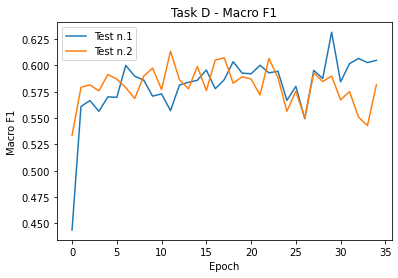

In [ ]:
# plot the F1-score on the validation set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    macro_F1 = [result['scores']['ALL']['Macro_F1'] for result in model_results]
    plt.plot(macro_F1, label='Test n.'+str(i+1))

plt.title('Task D - Macro F1')
plt.xlabel('Epoch')
plt.ylabel('Macro F1')
plt.legend()
plt.show()

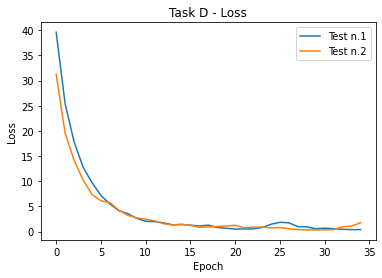

In [ ]:
# plot the loss on the training set over the epochs for each trained model

for i, model_results in enumerate(models_results):
    losses = [result['total_loss'] for result in model_results]
    plt.plot(losses, label='Test n.'+str(i+1))

plt.title('Task D - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# printing the saved information about the best model
best_model = models_results[0]
best_epoch_model = best_model[29]
pprint(best_epoch_model)

{'n_epoch': 29,
 'scores': {'ALL': {'F1': 0.7221812822402358,
                    'FN': 173,
                    'FP': 204,
                    'Macro_F1': 0.6314375147087462,
                    'Macro_P': 0.6103714159452712,
                    'Macro_R': 0.6546985560662469,
                    'P': 0.7060518731988472,
                    'R': 0.7390648567119156,
                    'TP': 490},
            'conflict': {'F1': 0.44776119402985076,
                         'FN': 16,
                         'FP': 21,
                         'P': 0.4166666666666667,
                         'R': 0.4838709677419355,
                         'TP': 15},
            'negative': {'F1': 0.6666666666666667,
                         'FN': 52,
                         'FP': 63,
                         'P': 0.6460674157303371,
                         'R': 0.688622754491018,
                         'TP': 115},
            'neutral': {'F1': 0.6129032258064515,
                        'FN': 32,
 